In [5]:
import os, glob, json
import pickle, dill
import pandas as pd
import re
import numpy as np
pd.set_option('display.max_colwidth', None)
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter, defaultdict
from tqdm import tqdm, trange
import statsmodels.formula.api as smf

In [2]:
# Load argument paths dataframe
per_path_df = pd.read_csv('per_path_df.csv')
for col in ['path_root_to_leaf','filtered_path_root_to_leaf']:
    per_path_df[col] = per_path_df[col].apply(lambda x: json.loads(x))
print(per_path_df.shape)
display(per_path_df.head())

(528531, 11)


,subtree_root_id,subtree_leaf_id,entry_order,degree_back_and_forth,convo_delta_pct,won_delta,convo_id,len,path_root_to_leaf,filtered_path_root_to_leaf,guid
0,t1_e45llf2,t1_e476c6z,19,2,0.052632,1,t3_973yb1,190.25,"[t1_e45llf2, t1_e45mtzr, t1_e45p1ij, t1_e45pmfu, t1_e45q2fr, t1_e45qn42, t1_e46iqqp, t1_e476c6z]","[t1_e45llf2, t1_e45mtzr, t1_e45p1ij, t1_e45pmfu, t1_e45q2fr, t1_e45qn42, t1_e46iqqp, t1_e476c6z]",t1_e45llf2 | t1_e476c6z
1,t1_e45lq41,t1_e45o2sv,20,3,0.052632,1,t3_973yb1,125.25,"[t1_e45lq41, t1_e45n24e, t1_e45nh0b, t1_e45o2sv]","[t1_e45lq41, t1_e45n24e, t1_e45nh0b, t1_e45o2sv]",t1_e45lq41 | t1_e45o2sv
2,t1_e45llf2,t1_e47qnva,19,2,0.052632,1,t3_973yb1,135.60,"[t1_e45llf2, t1_e45mtzr, t1_e45p1ij, t1_e45pmfu, t1_e45q2fr, t1_e45qn42, t1_e465cee, t1_e471v3w, t1_e47m16x, t1_e47qnva]","[t1_e45llf2, t1_e45mtzr, t1_e45p1ij, t1_e45pmfu, t1_e45q2fr, t1_e45qn42, t1_e465cee, t1_e471v3w, t1_e47m16x, t1_e47qnva]",t1_e45llf2 | t1_e47qnva
3,t1_e45n34c,t1_e45ntcf,27,2,0.052632,1,t3_973yb1,213.50,"[t1_e45n34c, t1_e45ntcf]","[t1_e45n34c, t1_e45ntcf]",t1_e45n34c | t1_e45ntcf
4,t1_e45l4gy,t1_e475ebc,15,2,0.052632,1,t3_973yb1,83.25,"[t1_e45l4gy, t1_e45m7si, t1_e46gi63, t1_e475ebc]","[t1_e45l4gy, t1_e45m7si, t1_e46gi63, t1_e475ebc]",t1_e45l4gy | t1_e475ebc


In [205]:
# Load argument text lookup 
comment_ID2text = pickle.load(open('comment_ID2text.pkl','rb'))

def print_full_argument_path(comments_path, cleaned=True):
    """Given a list of comment IDs `comments_path` associated with an argument, 
    prints the full argument exchange."""
    if cleaned:
        out = ["↳ "*n+f"{comment_ID2text[c_id]['cleaned_text'].strip()}"
               for n,c_id in enumerate(comments_path)]
    else:
        out = ["↳"*n+f"{comment_ID2text[c_id]['og_text'].strip()}"
               for n,c_id in enumerate(comments_path)]
    sep_char = '\n\n'+'='*70+'\n'
    print(sep_char.join(out))

In [206]:
# Examine sample argument
print_full_argument_path(per_path_df.iloc[1]['path_root_to_leaf'])

Bear with me but I see this as similar to the reason Freud's theories are often discredited: what the incel is proposing is [unfalsifiable](https://www.logicallyfallacious.com/tools/lp/Bo/LogicalFallacies/178/Unfalsifiability). If you don't have a girlfriend, you suck. Since you don't have a girlfriend, it must be because you suck. Since you suck, there is no hope for you, and any response you give to this will only further prove that their incel perspective is correct. Do you see where I'm going with this?

By their doctrine, they are always right. If you are okay with where you are, you are "coping" which is evidence that they are right. If you are not okay, you are taking the "blackpill" which is evidence that they are right.

There is no reason to engage with anyone in a debate that has a perspective like this. You should always assess whether anything you say can 'win' you the argument. In this case, every single avenue has been blocked off from you, so the argument is fallacious 

In [163]:
# Load predicate lexicons
lexicon_df = pd.read_csv('predicate_lexicons.csv')
lexicon_df = lexicon_df[['word','lexicon category','arguments','polysemous','exclude for polysemy?']]
lexicon_df = lexicon_df.loc[lexicon_df['exclude for polysemy?']!='y'].copy()
display(lexicon_df.head(10))
display(lexicon_df['lexicon category'].value_counts())

preds_set = set(lexicon_df['word'].values)
mwe_preds = lexicon_df.loc[lexicon_df['word'].apply(lambda x: len(x.split( )) > 1)]['word'].values
mwe_preds_set = set(mwe_preds)
print(f'Found {len(mwe_preds_set)} MWE predicates.')
print(mwe_preds)

,word,lexicon category,arguments,polysemous,exclude for polysemy?
0,affect,pretend,cc,y,n
1,feign,pretend,cc,y,n
2,dissemble,pretend,cc,y,n
3,pretend,pretend,cc,n,NaN
5,make believe,pretend,cc,n,NaN
6,declare,declare,cc,n,NaN
7,exclaim,declare,cc,n,NaN
8,proclaim,declare,cc,n,NaN
9,announce,declare,cc,y,n
10,cry out,declare,cc,n,NaN


think                     33
assert                    21
show                      20
say                       19
discover                  19
predict                   18
claim                     17
advance                   15
discover_via_reasoning    15
reason                    13
declare                   11
affirm                    11
deny                      11
repeat                    11
advise                    10
understand                 9
predict_sci                9
explain_sci                8
concede                    8
show_hidden                8
doubt                      7
emphasize                  7
promise                    7
express                    7
imply                      7
agree                      7
predict_tentative          6
pretend                    5
respond                    5
other_emotive              5
other_manner               4
other                      1
Name: lexicon category, dtype: int64

Found 12 MWE predicates.
['make believe' 'cry out' 'agree with' 'disagree with' 'talk about'
 'react to' 'make known' 'spell out' 'let on' 'mull over' 'work out'
 'work out' 'point out']


In [158]:
# Load other lexicons
with open('sci_ents.txt','r') as f:
    SE_set = set(f.read().splitlines())
print(f"Read in set of {len(SE_set)} scientific entities:\n")
print(", ".join(list(SE_set)[:10])+', ...')

disallowed_modals=set(['should','must','need'])

Read in set of 110 scientific entities:

research, growing_body, manuscript, url, report, academic_literature, assessment, sociologist, paper, specialist, ...


In [7]:
subj_pred_tups_per_subtree = dill.load(open(os.path.join('output','subj_pred_tups_per_subtree.dill'),'rb'))

def get_subj_pred_category_counts(path_guid, subj_set, pred_set, 
                                  subj_pred_tups_per_subtree=subj_pred_tups_per_subtree,
                                  verbose=False):
    """
    Counts the number of occurrences of a (subj, pred) combination within an argument path.
    Excludes negation, questions, quotes, etc.
    Example usage: 
        `get_subj_pred_category_counts('t1_e45l4gy | t1_e475ebc', {'you'}, WORD_CATEGORIES['concessive']`.
    """
    
    all_subj_pred_tups = subj_pred_tups_per_subtree[path_guid]
    
    if len(subj_set) == 1:
        in_category_tups = [x for x in all_subj_pred_tups
                            if (len(x['pred_neg']['text']) == 0) 
                            and (len(x['pred_q']['text'])==0) 
                            and (len(x['pred_cond']['text'])==0) 
                            and (x['in_quote']==False) 
                            and (len(set(x['pred_modal']['lemma']).intersection(disallowed_modals)) == 0) 
                            and (x['main_subj']['text'] is not None) 
                            and ((x['main_subj']['lemma'].lower() in subj_set) 
                                or (x['main_subj']['text'].lower() in subj_set))
                            and x['main_pred']['lemma'][0] in pred_set]
    else:
        in_category_tups = [x for x in all_subj_pred_tups
                            if (len(x['pred_neg']['text']) == 0) 
                            and (len(x['pred_q']['text'])==0) 
                            and (len(x['pred_cond']['text'])==0) 
                            and (x['in_quote']==False) 
                            and (len(set(x['pred_modal']['lemma']).intersection(disallowed_modals)) == 0) 
                            and (x['main_subj']['text'] is not None) 
                            and ((x['main_subj']['lemma'].lower() in subj_set) 
                                or (x['main_subj']['text'].lower() in subj_set)
                                or (len(set([l.lower() for l in x['subj_mods']['lemma']]).intersection(subj_set)) > 0))
                            and x['main_pred']['lemma'][0] in pred_set]
    if verbose:
        print(in_category_tups)
    return len(in_category_tups) 

In [164]:
# Extract ngram count features

SUBJ_CATEGORIES = {'first_sg': {'i'}, 'sci': SE_set}

WORD_CATEGORIES = {
    'concessive': set(lexicon_df.loc[lexicon_df['lexicon category']=='concede']['word'].values),#{'concede','admit','acknowledge','accept'}, #'recognize',
    'agreement': set(lexicon_df.loc[lexicon_df['lexicon category']=='agree']['word'].values),#{'agree','concur','assent','approve'},
    'assertive': set(lexicon_df.loc[lexicon_df['lexicon category']=='assert']['word'].values),#
    'factive': set(lexicon_df.loc[lexicon_df['lexicon category']=='discover']['word'].values) | \
               set(lexicon_df.loc[lexicon_df['lexicon category']=='affirm']['word'].values) | \
               set(lexicon_df.loc[lexicon_df['lexicon category']=='show']['word'].values) | \
               set(lexicon_df.loc[lexicon_df['lexicon category']=='understand']['word'].values),
    'nonfactive': set(lexicon_df.loc[lexicon_df['lexicon category']=='think']['word'].values),
    'disagreement': set(lexicon_df.loc[lexicon_df['lexicon category']=='deny']['word'].values),#{'disagree','dispute','reject','refute'}}
}

for subj_cat in SUBJ_CATEGORIES:
    for pred_cat in WORD_CATEGORIES:
        print(f"Getting (subj, pred) counts for ({subj_cat}, {pred_cat}) combinations...")
        per_path_df[f'count_{subj_cat}_{pred_cat}'] = \
            per_path_df['guid'].apply(lambda x: 
                                      get_subj_pred_category_counts(x, SUBJ_CATEGORIES[subj_cat],
                                                                    WORD_CATEGORIES[pred_cat]))

Getting (subj, pred) counts for (first_sg, concessive) combinations...
Getting (subj, pred) counts for (first_sg, agreement) combinations...
Getting (subj, pred) counts for (first_sg, assertive) combinations...
Getting (subj, pred) counts for (first_sg, factive) combinations...
Getting (subj, pred) counts for (first_sg, nonfactive) combinations...
Getting (subj, pred) counts for (first_sg, disagreement) combinations...
Getting (subj, pred) counts for (sci, concessive) combinations...
Getting (subj, pred) counts for (sci, agreement) combinations...
Getting (subj, pred) counts for (sci, assertive) combinations...
Getting (subj, pred) counts for (sci, factive) combinations...
Getting (subj, pred) counts for (sci, nonfactive) combinations...
Getting (subj, pred) counts for (sci, disagreement) combinations...


In [208]:
predictors = ['len','degree_back_and_forth','entry_order']
for subj_cat in SUBJ_CATEGORIES:
    for pred_cat in WORD_CATEGORIES:
        predictors.append(f'count_{subj_cat}_{pred_cat}')
print(f"Fitting a regression with the following predictors:\n\n {predictors}")

Fitting a regression with the following predictors:

 ['len', 'degree_back_and_forth', 'entry_order', 'count_first_sg_concessive', 'count_first_sg_agreement', 'count_first_sg_assertive', 'count_first_sg_factive', 'count_first_sg_nonfactive', 'count_first_sg_disagreement', 'count_sci_concessive', 'count_sci_agreement', 'count_sci_assertive', 'count_sci_factive', 'count_sci_nonfactive', 'count_sci_disagreement']


In [166]:
z_scored_per_path_df = per_path_df.copy()
for col in predictors:
    if col in {'len','degree_back_and_forth','entry_order'} or col.startswith('count_'):
        print(f'Z-scoring {col}...')
        z_scored_per_path_df[col] = stats.zscore(z_scored_per_path_df[col].values)

log_reg = smf.logit(f"won_delta ~ {' + '.join(predictors)}", data=z_scored_per_path_df).fit()
print(log_reg.summary())

Z-scoring len...
Z-scoring degree_back_and_forth...
Z-scoring entry_order...
Z-scoring count_first_sg_concessive...
Z-scoring count_first_sg_agreement...
Z-scoring count_first_sg_assertive...
Z-scoring count_first_sg_factive...
Z-scoring count_first_sg_nonfactive...
Z-scoring count_first_sg_disagreement...
Z-scoring count_sci_concessive...
Z-scoring count_sci_agreement...
Z-scoring count_sci_assertive...
Z-scoring count_sci_factive...
Z-scoring count_sci_nonfactive...
Z-scoring count_sci_disagreement...
Optimization terminated successfully.
         Current function value: 0.234183
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              won_delta   No. Observations:               528531
Model:                          Logit   Df Residuals:                   528515
Method:                           MLE   Df Model:                           15
Date:                Fri, 06 Jan 2023   Pseudo R-squ.:                 0.

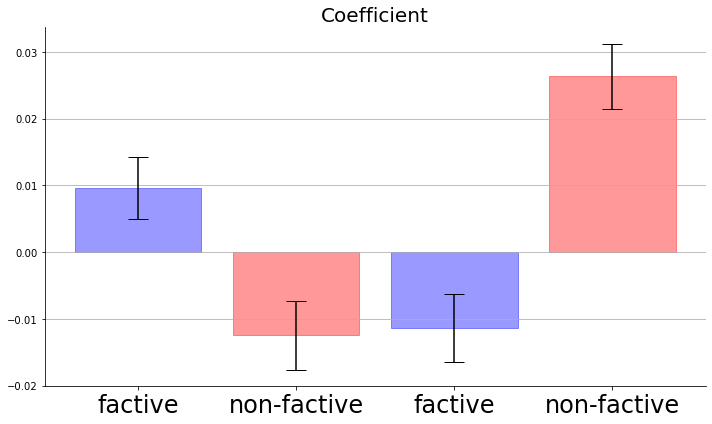

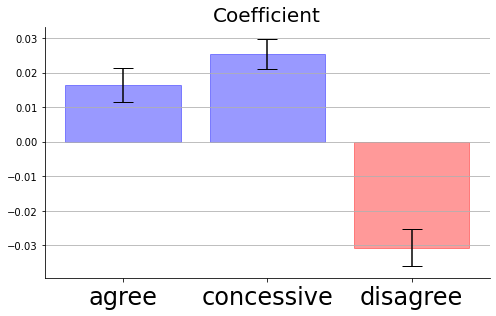

In [167]:
# Plot regression coefficients

to_plot = pd.DataFrame({
    'feature': ['factive','non-factive']*2,
    'subject': ['sci']*2+['I']*2,
    'coeff': [log_reg.params[feat] for feat in 
              ['count_sci_factive','count_sci_nonfactive',
               'count_first_sg_factive','count_first_sg_nonfactive',]],
    'cat': ['high','low']*2,
    'err': [log_reg.bse[feat] for feat in 
            ['count_sci_factive','count_sci_nonfactive',
               'count_first_sg_factive','count_first_sg_nonfactive',]],
})

cmap = {'high': 'blue',
        'low': 'red'}

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(to_plot.index.values, to_plot['coeff'], yerr=to_plot['err'], align='center', alpha=0.4, 
       ecolor='black', capsize=10)
ax.set_ylabel('',fontsize=24)
ax.set_title('Coefficient',fontsize=20)
ax.set_xticks(to_plot.index.values)
ax.set_xticklabels(to_plot['feature'],fontsize=24,rotation=0)
for i,bar in enumerate(bars):
    color = cmap[to_plot['cat'].values[i]]
    bar.set_color(color)
ax.yaxis.grid(True)
sns.despine()

# Save the figure and show
plt.tight_layout()
if not os.path.exists('figs'):
    os.mkdir('figs')
plt.savefig('figs/PA_coeffs.png',dpi=1000,transparent=True)

to_plot = pd.DataFrame({
    'feature': ['agree','concessive','disagree'],
    'subject': ['I']*3,
    'coeff': [log_reg.params[feat] for feat in 
              ['count_first_sg_agreement','count_first_sg_concessive','count_first_sg_disagreement']],
    'cat': ['high','high','low'],
    'err': [log_reg.bse[feat] for feat in 
            ['count_first_sg_agreement','count_first_sg_concessive','count_first_sg_disagreement']],
})

fig, ax = plt.subplots(figsize=(7,4.5))
bars = ax.bar(to_plot.index.values, to_plot['coeff'], yerr=to_plot['err'], align='center', alpha=0.4, 
       ecolor='black', capsize=10)
ax.set_ylabel('',fontsize=24)
ax.set_title('Coefficient',fontsize=20)
ax.set_xticks(to_plot.index.values)
ax.set_xticklabels(to_plot['feature'],fontsize=24,rotation=0)
for i,bar in enumerate(bars):
    color = cmap[to_plot['cat'].values[i]]
    bar.set_color(color)
ax.yaxis.grid(True)
sns.despine()

# Save the figure and show
plt.tight_layout()
plt.savefig('figs/IA_coeffs.png',dpi=1000,transparent=True)